# **Initialization**

In [90]:
# import the necessary libraries

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.collections import LineCollection
from matplotlib import colorbar
from matplotlib.ticker import PercentFormatter
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from IPython.core.pylabtools import figsize
from google.colab import files
import matplotlib.ticker as mtick
from scipy.stats import norm
from scipy.optimize import curve_fit
import math

from google.colab import drive

In [91]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# define file path in google drive
file_path1="/content/gdrive/My Drive/Colab Notebooks/folder_name/file_name.csv"

# open file
drive.mount('/content/gdrive')
open(file_path1).read()

# **Functions**

In [119]:
# define a function to retain only the beads having the whole set of frames
# cut to a certain number of beads
# zero the trajectories (each trajectory starts from the origin)
# convert from px to microns

def data_preparation (file_path, num_beads, micron_pixel_ratio, num_frames):

  # making dataframe
  data = pd.read_csv(file_path)

  # create a numpy array with only the columns of interest
  array=data[['Trajectory','Frame','x','y']].to_numpy(dtype=object)  #For a mix of numeric and non-numeric types, the output array will have object dtype.

  rows, columns = array.shape  # this gives the # rows and columns of the array
  num_init=array[rows-1,0]

  print(f"The number of beads tracked in ImageJ is {num_init}.")

  # retain only the beads with all frames

  # count n. frames for each bead
  count_frames={}   # associative array/dictionary composed of a collection of (key, value) pairs, such that each possible key appears at most once in the collection.

  for i in array[:,0]:
    if i in count_frames:
        count_frames[i] +=1
    else:
        count_frames[i] =1

  maxframes=num_frames

  filtered=[]

  for n in count_frames.keys():       # dictionary.keys() gives the list of keys/items in the dictionary; in our case, it's the list of PARTICLE #
    if count_frames[n]==maxframes:
      filtered.append(n)

  num_filt=len(filtered)
  print(f"The number of particles that have the whole set of {num_frames} frames is {num_filt}.")

  # create a new array with only the beads having all frames
  filter_arr=[]   # Create empty array with True or False

  for element in range (0,rows):

    if array[element,0] in filtered:
        filter_arr.append(True)
    else:
        filter_arr.append(False)

  newarray=array[filter_arr]

  # use only a certain number of beads
  cut_frames=num_beads*num_frames
  cut_array=newarray[0:cut_frames,:]
  tot=len(cut_array)

  # zeroing the trajectories so that they all start from the center of the plot
  zero_arr=np.zeros(cut_array.shape)
  zero_arr[:,0]=cut_array[:,0]
  zero_arr[:,1]=cut_array[:,1]

  # zero, convert to microns
  for element in range(0,tot):
    if cut_array[element,1]==0:     # if this is the 1st frame for a bead
      start=element
      deltax=cut_array[element,2] # x distance from the origin
      deltay=cut_array[element,3] # y distance from the origin

    zero_arr[element,2]=(cut_array[element,2]-deltax)*micron_pixel_ratio  # change x
    zero_arr[element,3]=-(cut_array[element,3]-deltay)*micron_pixel_ratio  # change y

  return zero_arr

In [94]:
# select trajectory function

def select_traj (zero_arr, traj_n, num_frames):
  tot=len(zero_arr)

  for i in range (0,tot):
    if zero_arr[i,0] == traj_n and zero_arr[i,1]==0:
      start=i
      end=start+num_frames

  single_traj=zero_arr[start:end]
  return single_traj

In [95]:
# define function to generate medusa plot
# the input array must have 4 columns in the order 'Trajectory','Frame','x','y' (automatic if the data_preparation function is used)

def medusa_plot (zero_arr, x_scale,y_scale, xtick_step, ytick_step, frame_rate, num_frames, cmap):
  # count n. beads based on the input array
  num_beads=int(len(zero_arr)/num_frames)
  tot=len(zero_arr)

  # fig settings
  frame_i=np.arange(0,num_frames*(1/frame_rate)/60,(1/frame_rate)/60)
  fig, ax = plt.subplots(figsize=(12,10))
  plt.axis([-x_scale,x_scale,-y_scale,y_scale])
  # Create a continuous norm to map from data points to colors
  norm = plt.Normalize(frame_i.min(), frame_i.max())

  # plot
  for element in range(0,tot):
    if zero_arr[element,1]==0:     # if this is the 1st frame for a bead
      start=element

    if zero_arr[element,1]==num_frames-1:
      x=zero_arr[start:element,2]
      y=zero_arr[start:element,3]
      points = np.array([x, y]).T.reshape(-1, 1, 2)
      segments = np.concatenate([points[:-1], points[1:]], axis=1)

      trajectory = LineCollection(segments, cmap=cmap, norm=norm, linewidth=6)
      line = ax.add_collection(trajectory)

      #set the colour according to the time frame data
      trajectory.set_array(frame_i)

  cbar_min=min(frame_i)
  cbar_max=max(frame_i)
  cbar_step=5
  cbar=fig.colorbar(trajectory, ax=ax,ticks=np.arange(cbar_min, cbar_max+cbar_step, cbar_step))
  plt.title(f"particles n={num_beads}", fontsize=24)
  cbar.set_label("Time (min)",fontsize=28)
  cbar.ax.tick_params(labelsize=24)

  plt.xlabel("x position (μm)", fontsize=28)
  plt.ylabel("y position (μm)", fontsize=28)
  ax.set_xticks(np.arange(-x_scale, x_scale+xtick_step, xtick_step))

  plt.setp(ax.get_xticklabels(), fontsize=24)
  ax.set_yticks(np.arange(-y_scale, y_scale+ytick_step, ytick_step))

  plt.setp(ax.get_yticklabels(), fontsize=24)
  #plt.grid()
  #plt.savefig('medusa.png', dpi='300', transparent=True)
  ax.patch.set_alpha(0.0)
  fig.patch.set_alpha(0.0)
  #fig.savefig('medusa.png', format='png', dpi='300')
  plt.show()

In [100]:
# net displacement function and plotting function

def net_displacement (zero_arr,num_frames):

  # count n. beads based on the input array
  num_beads=int(len(zero_arr)/num_frames)
  tot=len(zero_arr)

  net_displ=[]

  for element in range(0,tot):
    if zero_arr[element,1]==0:     # 1st frame for a bead
      initial_x=zero_arr[element,2]
      initial_y=zero_arr[element,3]

    if zero_arr[element,1]==num_frames-1:   # last frame for a bead
      final_x=zero_arr[element,2]
      final_y=zero_arr[element,3]
      net_d=np.sqrt((final_x - initial_x)**2 + (final_y - initial_y)**2)
      net_displ.append(net_d)

  return net_displ

########################################################################################################################

def plot_net_displacement (net_displ):    #array with distance travelled for each bead
  # count n. beads based on the input array
  num_beads=int(len(net_displ))
  mean=np. average(net_displ, axis=0)

  print(f"The mean net displacement is {round(mean,3)} μm")

  fig, ax = plt.subplots(figsize=(9,8))

  ax = sns.boxplot(y=net_displ,palette="Blues",saturation=0.65, width=0.4, linewidth=2,notch=True)
  sns.swarmplot(y=net_displ, marker="o", alpha=0.7,color=".25")
  plt.ylabel('Net displacement (μm)', fontsize=20)
  plt.setp(ax.get_yticklabels(), fontsize=16)
  ax.set_title(f'Particle Displacement n={num_beads}', fontsize=20)
  ax.set(ylim=(-1, 10))
  ax.autoscale()
  plt.grid()

In [102]:
# instantaneous velocity function (averaged at each frame)

def instantaneous_velocity_xframe (zero_arr, frame_rate, num_frames):
  inst_v=[]
  inst_v.append(0)


  tot=len(zero_arr)
  num_beads=int(tot/num_frames)
  frame_i=np.arange(0,num_frames*(1/frame_rate),(1/frame_rate))  # assign the time to the frame#

  for t in range (1,num_frames):
    d=0
    for element in range (0,tot):
      if zero_arr[element,1]==t:
        delta=np.sqrt((zero_arr[element,2] - zero_arr[element-1,2])**2 + (zero_arr[element,3] - zero_arr[element-1,3])**2)
        d=d+delta

    avg=d/num_beads
    v=avg/(1/frame_rate)*1000      # nm/s
    inst_v.append(v)

  return inst_v

In [123]:
# log-MSD vs log-lagtime and alpha value calculation

def MSD_logfit (zero_arr, frame_rate, num_frames, use_frames):
  tot=len(zero_arr)
  num_beads=int(tot/num_frames)
  lagtime= range(1,num_frames)  #expressed in #frames, lag times=5s, 10s, 15s, etc
  lagtime_s=np.linspace((1/frame_rate),num_frames*(1/frame_rate),num_frames-1) # lagtime in seconds

  split_arr=[]  # array of particle trajectories (arrays of x, y positions)
  msd_list=[] # for each lag time
  alpha_list=[] # it collects the alpha lists for each particle/trajectory
  intercept_list=[]

  for element in range (0,tot):
    if zero_arr[element,1]==0:
      single_traj=zero_arr[element:element+num_frames,:]
      split_arr.append(single_traj)

  fig, ax = plt.subplots(figsize=(8,6))

  for bead in range (0,num_beads):
    one_traj=split_arr[bead]
    msd_1traj=[]       # it contains the msd at each lag time for a single traj
    for i in lagtime:
      sd_list=[]

      for j in range(0,num_frames-i):
        sd=(one_traj[j+i,2]-one_traj[j,2])**2 + (one_traj[j+i,3]-one_traj[j,3])**2 # column 2 contains x coord, col 3 contains y coord
        sd_list.append(sd)

      avg_sd=np.mean(sd_list)  # msd at a lag time for a single traj
      msd_1traj.append(avg_sd)

    msd_list.append(msd_1traj) # this will contain the lists of msd for all the beads

    # log-log fit to find the alpha value for one trajectory
    x=np.log(lagtime_s[0:use_frames])
    y=np.log(msd_1traj[0:use_frames])
    plt.scatter(x,y,facecolors="white", linewidths=0.5,edgecolors="black", alpha=1, marker="o")

    m, b = np.polyfit(x,y, 1)
    alpha_list.append(m)
    intercept_list.append(b)

  alpha=np.mean(alpha_list)
  intercept=np.mean(intercept_list)

  def powerlaw (x,c):
    return c * (x**alpha)
  avg_msd=[]  # avg msd at each lagtime

  for i in lagtime:
    sum=0
    for k in range(0,num_beads):
      l=msd_list[k]
      sum=sum+l[i-1]  # range of lagtime (in terms of frames) goes from 1 to max
    avg=sum/num_beads
    avg_msd.append(avg)

  popt, pcov = curve_fit(powerlaw, lagtime_s, avg_msd)

  plt.plot(x, alpha*x+intercept, 'r-',
         label='fit: c=%5.3f' % tuple(popt))

  ax.text(0.04,0.95,f"MSD={round(popt[0],5)}$t^{{{round(alpha,3)}}}$",fontsize=24,horizontalalignment='left',verticalalignment='top',transform=ax.transAxes)

  plt.xlabel("Log lagtime (s)",fontsize=24)
  plt.ylabel("Log MSD ($μm^2$)",fontsize=24)
  plt.setp(ax.get_xticklabels(), fontsize=20)
  plt.setp(ax.get_yticklabels(), fontsize=20)
  # note: the plot is on a logarithm scale

In [104]:
# create alpha value array from selected number of frames

def alpha_value (zero_arr, frame_rate, num_frames,use_frames):
  tot=len(zero_arr)
  num_beads=int(tot/num_frames)
  lagtime= range(1,num_frames)  #expressed in #frames, lag times=5s, 10s, 15s, etc
  lagtime_s=np.linspace((1/frame_rate),num_frames*(1/frame_rate),num_frames-1) # lagtime in seconds

  split_arr=[]  # array of particle trajectories (arrays of x, y positions)
  alpha_list=[] # it collects the alpha lists for each particle/trajectory

  for element in range (0,tot):
    if zero_arr[element,1]==0:
      single_traj=zero_arr[element:element+num_frames,:]
      split_arr.append(single_traj)

  for bead in range (0,num_beads):
    one_traj=split_arr[bead]
    msd_1traj=[]       # it contains the msd at each lag time for a single traj
    for i in lagtime:
      sd_list=[]

      for j in range(0,num_frames-i):
        sd=(one_traj[j+i,2]-one_traj[j,2])**2 + (one_traj[j+i,3]-one_traj[j,3])**2 # column 2 contains x coord, col 3 contains y coord
        sd_list.append(sd)

      avg_sd=np.mean(sd_list)  # msd at a lag time for a single traj
      msd_1traj.append(avg_sd)

    x=np.log(lagtime_s[0:use_frames])
    y=np.log(msd_1traj[0:use_frames])

    m, b = np.polyfit(x,y, 1)
    alpha_list.append(m)
  return alpha_list

########################################################################################

def plot_alpha_value (alpha_list):    #array with distance travelled for each bead
  # count n. beads based on the input array
  num_beads=int(len(alpha_list))
  mean=np. average(alpha_list, axis=0)

  print(f"The mean alpha value is {round(mean,3)}")

  fig, ax = plt.subplots(figsize=(9,8))

  ax = sns.boxplot(y=alpha_list,palette="Oranges",saturation=0.65, width=0.4, linewidth=2,notch=True)
  sns.swarmplot(y=alpha_list, marker="o", alpha=0.7,color=".25")

  plt.ylabel('Alpha values', fontsize=20)
  plt.setp(ax.get_yticklabels(), fontsize=16)
  ax.set_title(f'n={num_beads}', fontsize=20)
  #ax.set(ylim=(-1, 10))
  ax.autoscale()
  plt.grid()

In [105]:
# Function to calculate the angle between two vectors
def calculate_angle(x1, y1, x2, y2, x3, y3):
    # Vector 1 (from point A to B)
    v1_x = x2 - x1
    v1_y = y2 - y1

    # Vector 2 (from point B to C)
    v2_x = x3 - x2
    v2_y = y3 - y2

    # Dot product of v1 and v2
    dot_product = v1_x * v2_x + v1_y * v2_y

    # Magnitudes of v1 and v2
    mag_v1 = math.sqrt(v1_x**2 + v1_y**2)
    mag_v2 = math.sqrt(v2_x**2 + v2_y**2)

    # Calculate cosine of the angle
    cos_theta = dot_product / (mag_v1 * mag_v2)

    # Ensure the cosine value is within valid range (-1 to 1) to avoid math domain errors
    cos_theta = max(-1, min(1, cos_theta))

    # Calculate the angle in radians and then convert to degrees
    theta = math.acos(cos_theta)
    angle_degrees = math.degrees(theta)

    return angle_degrees

########################################################################################

# apparent angular displacement (calculate the angle of changing trajectory)

def angular_displacement (zero_arr,num_frames):

  # count n. beads based on the input array
  num_beads=int(len(zero_arr)/num_frames)
  tot=len(zero_arr)

  ang_displ=[]

  for element in range(0,tot):
    if zero_arr[element,1]==0:
      ang_onebead=[]

    if zero_arr[element,1]!=0 and zero_arr[element,1]!= 1:     # find third point

      x1=zero_arr[element-2,2]    # 1st point of vector
      y1=zero_arr[element-2,3]

      x2=zero_arr[element-1,2]    # 2nd point
      y2=zero_arr[element-1,3]

      x3=zero_arr[element,2]      # current position - 3rd point
      y3=zero_arr[element,3]

      angle=calculate_angle(x1=x1, y1=y1, x2=x2, y2=y2, x3=x3, y3=y3)
      ang_onebead.append(angle)

    if zero_arr[element,1]==num_frames-1:   # last frame for a bead
      ang_displ.append(ang_onebead)

  return ang_displ

########################################################################################
#plot in a polar histogram

def plot_polar_hist_height(angle_list, num_bins):
    # Convert angles from degrees to radians
    angles_radians = np.deg2rad(angle_list)

    # Compute histogram
    counts, bin_edges = np.histogram(angles_radians, bins=num_bins)

    # Normalize counts for color mapping
    norm = mcolors.Normalize(vmin=counts.min(), vmax=counts.max())
    cmap = plt.cm.viridis_r  # Colormap

    # Calculate the width of each bin
    bin_width = np.diff(bin_edges)*3

    # Create a polar plot
    fig, ax = plt.subplots(figsize=(6,6), dpi=300, subplot_kw={'projection': 'polar'})

    ax.set_thetamax(180)  # Limit to 180 degrees

    # Assign colors based on the normalized frequency
    colors = cmap(norm(counts))

    # Create bars
    bars = ax.bar(bin_edges[:-1], counts, width=bin_width, edgecolor='none', bottom=0.0, align='edge', color=colors, alpha=0.8, linewidth=1)

    # Customize the plot appearance
    ax.spines['polar'].set_linewidth(2.5)  # Outer circle linewidth
    ax.tick_params(axis='x', labelsize=18, pad=15)  # Angular tick size
    ax.tick_params(axis='y', labelsize=18)  # Radial tick size
    ax.set_xticks(np.deg2rad([0, 30, 60, 90, 120, 150, 180]))  # Angular ticks
    #ax.set_rticks([0, 4, 8, 12, 16, 20])  # Adjust the radial ticks spacing (you can change these values as needed)
    ax.patch.set_alpha(0.0)
    fig.patch.set_alpha(0.0)

    plt.show()

# **Results**

In [106]:
#data preparation
arr1 =data_preparation(file_path=file_path1, num_beads=50, micron_pixel_ratio=0.11, num_frames=91)

The number of beads tracked in ImageJ is 5.
The number of particles that have the whole set of 91 frames is 4.


In [107]:
print(arr1)

[[ 1.000000e+00  0.000000e+00  0.000000e+00 -0.000000e+00]
 [ 1.000000e+00  1.000000e+00  5.599000e-02  2.684000e-01]
 [ 1.000000e+00  2.000000e+00  6.721000e-02  4.777300e-01]
 ...
 [ 4.000000e+00  8.800000e+01  5.102900e+00 -3.463306e+01]
 [ 4.000000e+00  8.900000e+01  5.165600e+00 -3.507592e+01]
 [ 4.000000e+00  9.000000e+01  5.227200e+00 -3.549469e+01]]


In [108]:
print(type(arr1))

<class 'numpy.ndarray'>


## **individual motor particle**

In [109]:
traj1=select_traj (zero_arr=arr1, traj_n=3, num_frames=91)

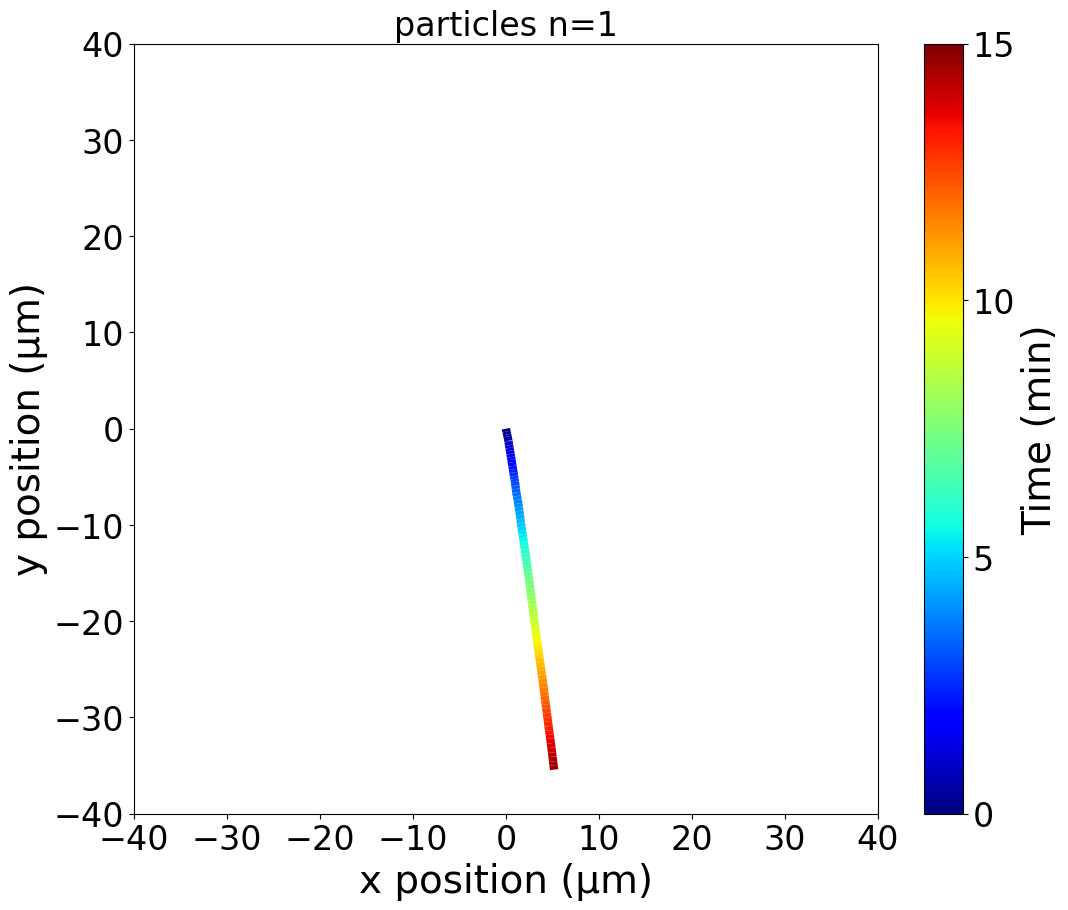

In [110]:
medusa_plot (zero_arr=traj1, x_scale=40, y_scale=40, xtick_step=10, ytick_step=10, frame_rate=0.1, num_frames=91, cmap='jet')

The mean net displacement is 36.244 μm


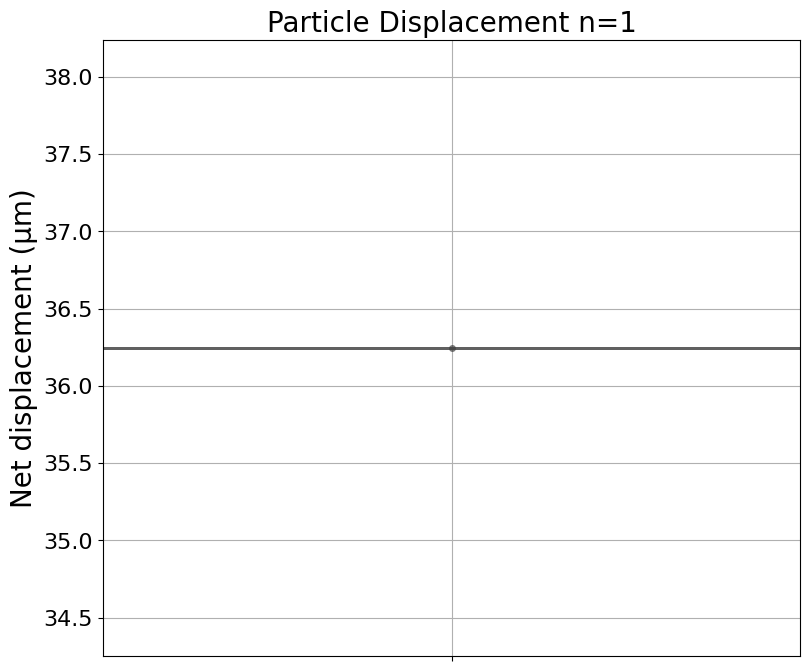

In [112]:
# Net displacement - data prep required
net_arr1=net_displacement (zero_arr=traj1, num_frames=91)
plot_net_displacement (net_displ=net_arr1)

# export csv file with the net displacement of each bead
# choose file name
file_name="traj1-net-displ.csv"

output = pd.DataFrame(net_arr1, columns=['Net Displacement'])

output.to_csv(file_name)
#files.download(file_name) #remove the comment symbol to download

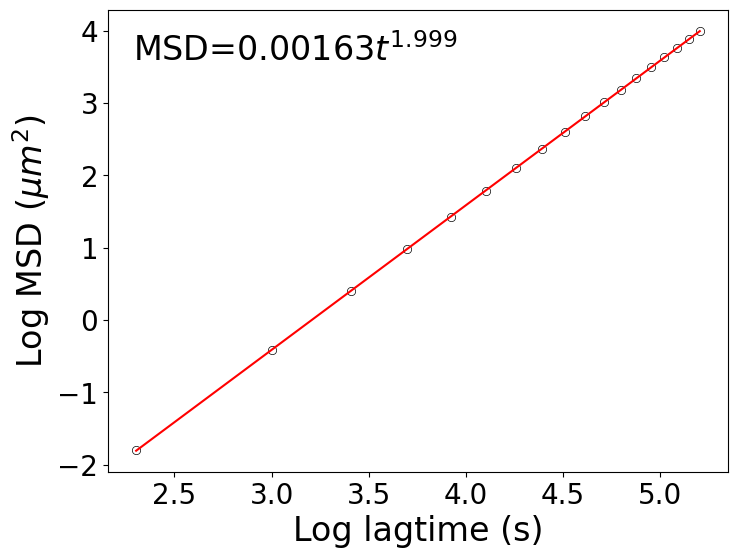

In [125]:
# logMSD-loglagtime fitting - 20%

MSD_logfit (zero_arr=traj1, num_frames=91, use_frames=18, frame_rate=0.1)

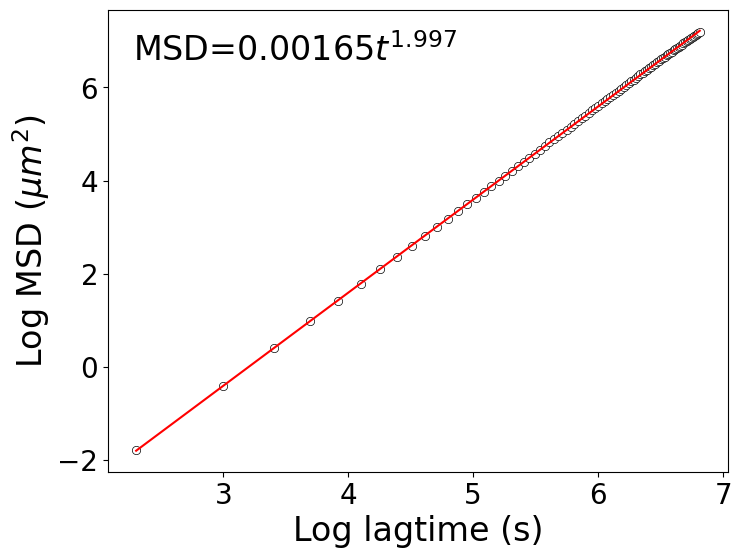

In [126]:
MSD_logfit (zero_arr=traj1, num_frames=91, use_frames=91, frame_rate=0.1)

The mean alpha value is 1.999
The mean alpha value is 1.999


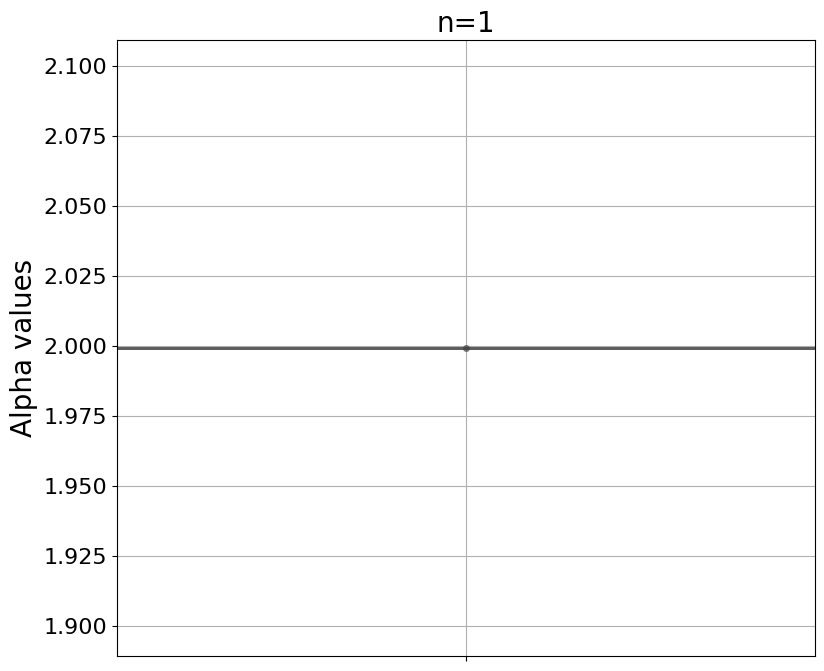

In [116]:
# alpha value

a1=alpha_value (zero_arr=traj1, num_frames=91, use_frames=18, frame_rate=0.1) # using 20% of <MSD> vs lagtime curve
plot_alpha_value (alpha_list=a1)
print(f"The mean alpha value is {round(np.mean(a1),3)}")

# export csv file with the alpha value
# choose file name
file_name="alpha.csv"

output = pd.DataFrame(a1, columns=['alpha value']) # alpha value for each bead/traj
output.to_csv(file_name)
#files.download(file_name) #remove the comment symbol to download

In [117]:
inst_v1=instantaneous_velocity_xframe (zero_arr=traj1, frame_rate=0.1, num_frames=91)

print(np.mean(inst_v1))
# export csv file with the instantaneous vel
# choose file name
file_name="instav-xframe.csv"

output = pd.DataFrame(inst_v1, columns=['Instantaneous velocity']) # insta vel averaged for each bead

output.to_csv(file_name)
#files.download(file_name) #remove the comment symbol to download

39.83887446815461


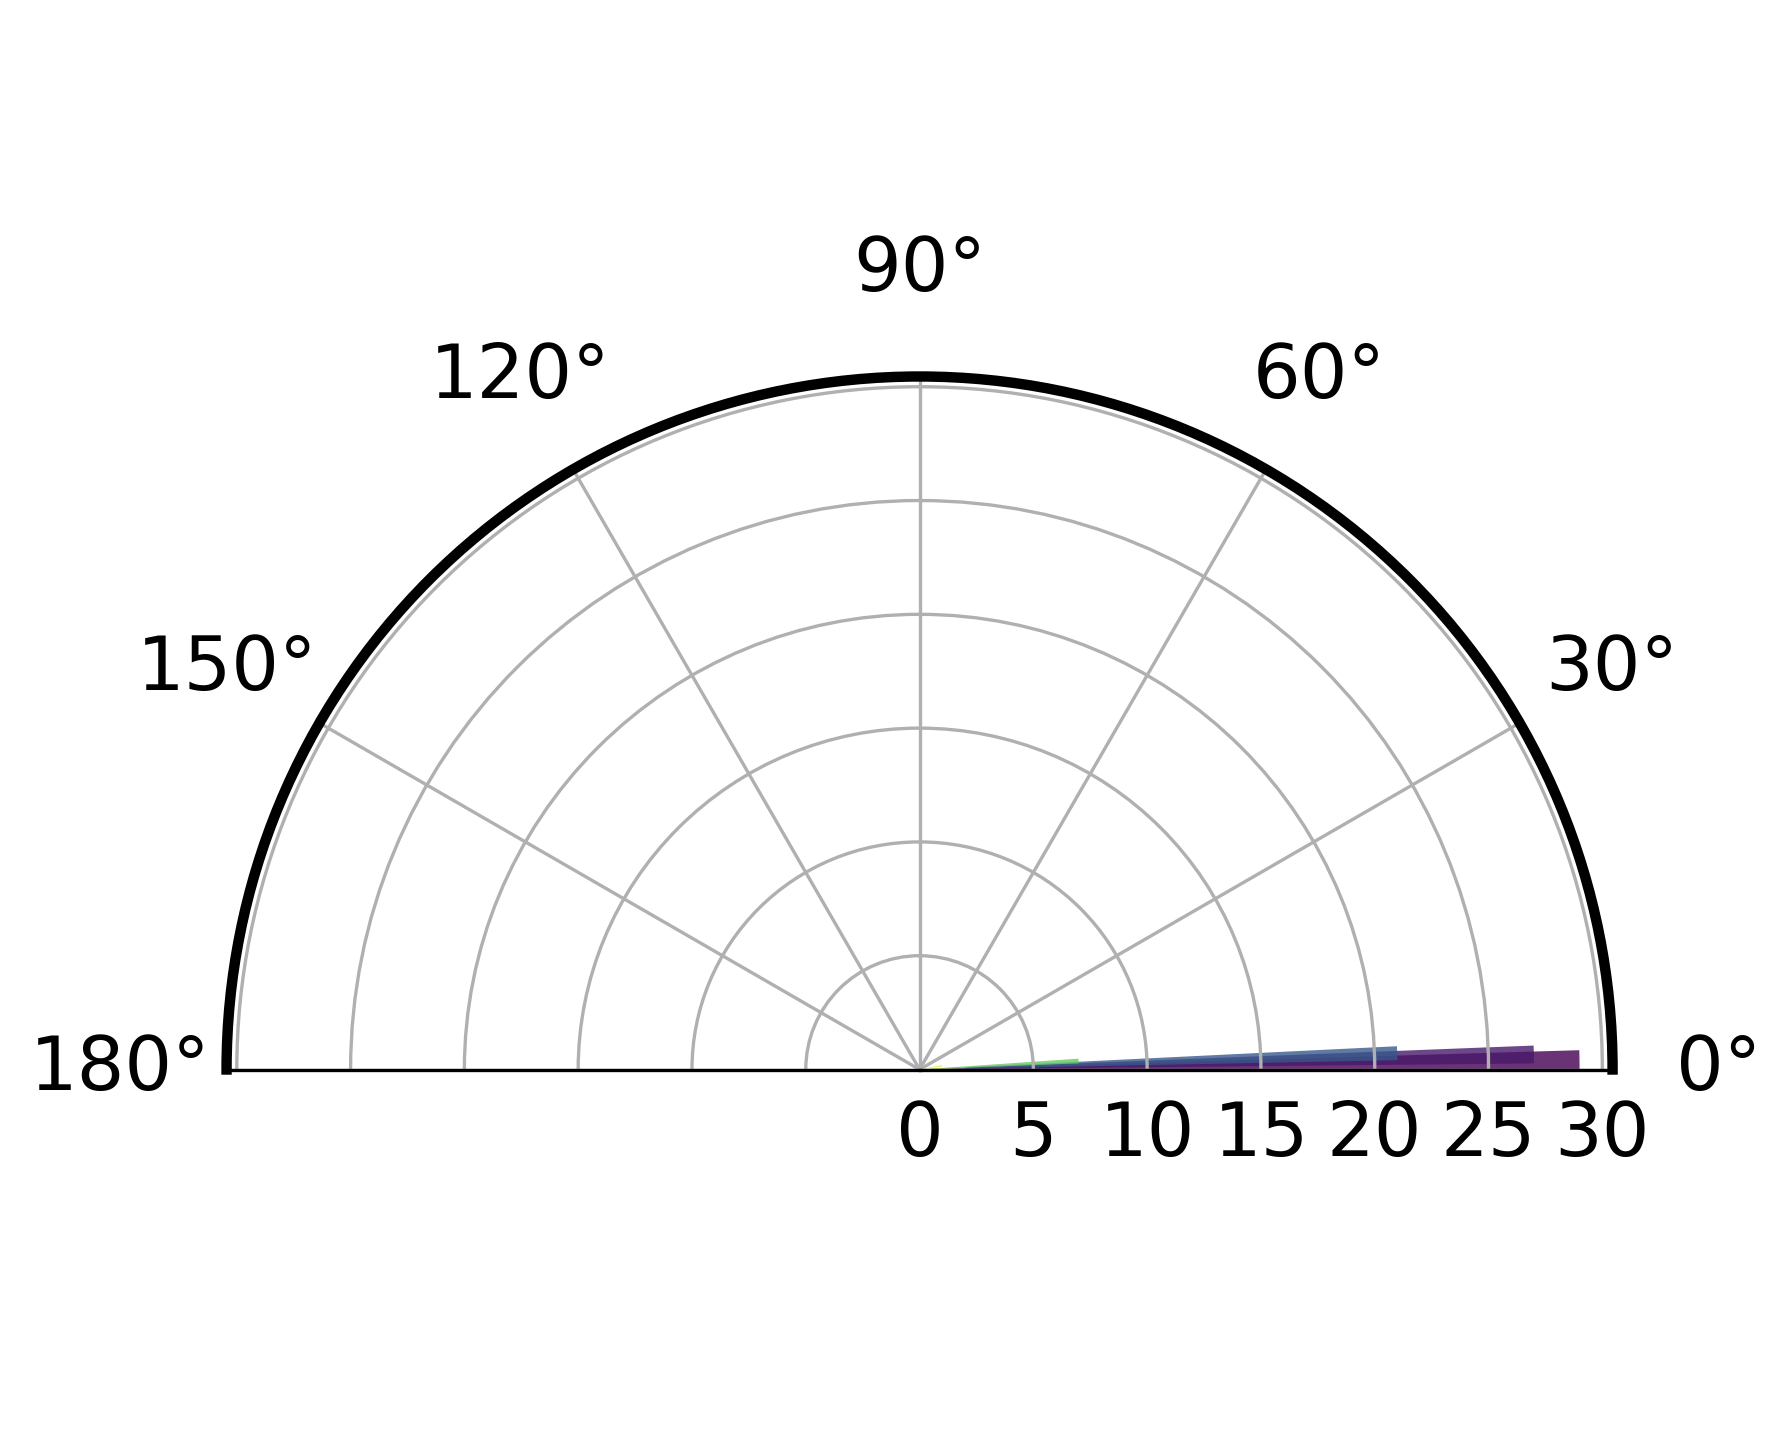

In [118]:
# calculate angular displacements and plot polar histograms (color of the bar is determined by its height)
ang=angular_displacement (zero_arr=traj1, num_frames=91)
plot_polar_hist_height (angle_list=ang, num_bins=18)